In [1]:
import pandas as pd
import numpy as np

from PIL import Image

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


from torchvision import transforms
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn, torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import Dataset

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from data import IMAGE_TRANSFORMER, FERDataset
from model_utils import train_val_test_split, MultiClassClassifier, DataLoaders, torch_active_device
from models import SimpleCNNModel

2024-01-24 13:31:42.475202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_data = pd.read_csv("dataset/fer_2013/train.csv")
train_data.head()

test_data = pd.read_csv("dataset/fer_2013/test.csv")

In [5]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.
label_map = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

train_data["emotion"] = train_data["emotion"].apply(lambda x: label_map[x])

In [6]:
# convert string bytes into image arrays
train_data['pixels'] = train_data['pixels'].apply(lambda x: np.fromstring(x, dtype='int', sep=' ').reshape(48, 48) / 255)

In [7]:
train_data.head()

,emotion,pixels
0,angry,"[[0.27450980392156865, 0.3137254901960784, 0.3..."
1,angry,"[[0.592156862745098, 0.5882352941176471, 0.576..."
2,fear,"[[0.9058823529411765, 0.8313725490196079, 0.61..."
3,sad,"[[0.09411764705882353, 0.12549019607843137, 0...."
4,neutral,"[[0.01568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0..."


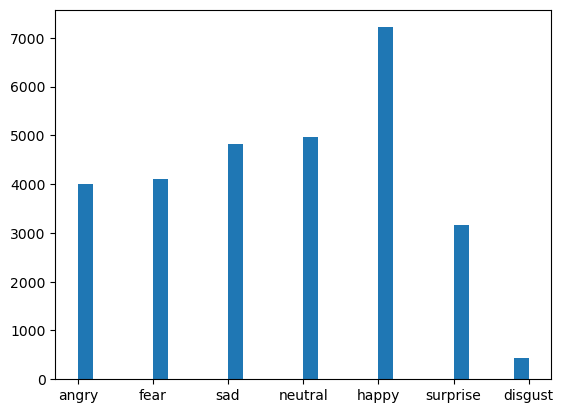

In [8]:
# spread of target classes
plt.hist(train_data['emotion'], bins=30)
plt.show()

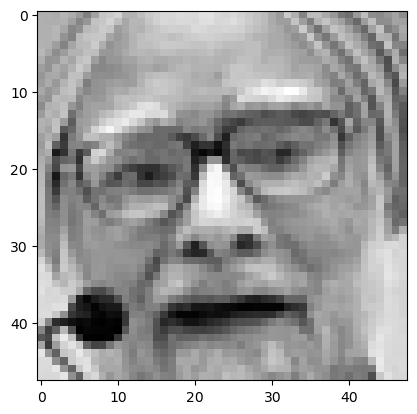

In [9]:
plt.imshow(train_data['pixels'].iloc[1], cmap='gray')

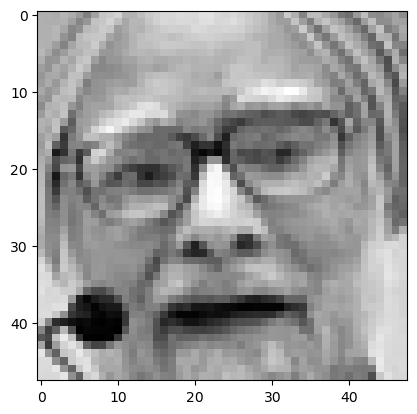

In [10]:
# Apply image transforms
plt.imshow(IMAGE_TRANSFORMER(train_data['pixels'].iloc[1]).squeeze(0), cmap='gray')

In [11]:
x_train, y_train, x_val, y_val, _, _ = train_val_test_split(train_data['pixels'], train_data['emotion'], val_size=0.1, stratify=True, test_size=0, shuffle=True)

X_train: (25838,)
X_val: (2871,)


In [12]:
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_val = target_encoder.transform(y_val)

In [13]:
num_classes = target_encoder.classes_.shape[0]

### Pytorch

In [14]:
train_dataset = FERDataset(x_train, y_train, device=torch_active_device)
val_dataset = FERDataset(x_val, y_val, device=torch_active_device)

data = DataLoaders(batch_size=32)(train_dataset, val_dataset, test_dataset=None)

In [15]:
model = SimpleCNNModel(num_classes=num_classes)
print(model)

SimpleCNNModel(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (cnn_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (cnn_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [16]:
model, outputs = MultiClassClassifier.train(model,
                          train_loader=data.train_loader, val_loader=data.val_loader,
                          num_epochs=3, optimizer=optimizers.Adam,
                          optimizer_params={
                              "lr": 1e-3
                          }, class_weights=None,
                          return_outputs=True)

Epoch 1/3:   0%|          | 0/807 [00:00<?, ?it/s]

Predicted labels counts in training data:
(array([0., 1., 2., 3., 4., 5., 6.]), array([1808,    4, 1339, 8815, 6074, 4775, 3023]))
Epoch 1/3 | Training loss: 1.497 | Train accuracy 2: 0.415 | Val loss: 1.346 | Val accuracy: 0.492


Epoch 2/3:   0%|          | 0/807 [00:00<?, ?it/s]

Predicted labels counts in training data:
(array([0., 1., 2., 3., 4., 5., 6.]), array([3077,   42, 1827, 7404, 5507, 4929, 3052]))
Epoch 2/3 | Training loss: 1.279 | Train accuracy 2: 0.511 | Val loss: 1.266 | Val accuracy: 0.512


Epoch 3/3:   0%|          | 0/807 [00:00<?, ?it/s]

Predicted labels counts in training data:
(array([0., 1., 2., 3., 4., 5., 6.]), array([3181,  142, 2283, 7117, 5133, 5035, 2947]))
Epoch 3/3 | Training loss: 1.165 | Train accuracy 2: 0.556 | Val loss: 1.218 | Val accuracy: 0.54


In [17]:
y_pred = MultiClassClassifier.predict(model, data.val_loader)
print(f"Validation accuracy score: {accuracy_score(y_val, y_pred)}")
print(f"Classification report: \n {classification_report(y_val, y_pred, zero_division=0)}")

Predictions:   0%|          | 0/89 [00:00<?, ?it/s]

Validation accuracy score: 0.5353535353535354
Classification report: 
               precision    recall  f1-score   support

           0       0.48      0.36      0.41       399
           1       0.59      0.23      0.33        44
           2       0.34      0.30      0.32       410
           3       0.73      0.80      0.76       722
           4       0.48      0.59      0.53       496
           5       0.42      0.36      0.39       483
           6       0.60      0.69      0.64       317

    accuracy                           0.54      2871
   macro avg       0.52      0.48      0.48      2871
weighted avg       0.52      0.54      0.53      2871


### Tensorflow

In [ ]:
x_train_keras = tf.stack([np.array(IMAGE_TRANSFORMER(x)).reshape(48, 48, 1) for x in x_train])
x_val_keras = tf.stack([np.array(IMAGE_TRANSFORMER(x)).reshape(48, 48, 1) for x in x_val])

y_train_keras = tf.stack(keras.utils.to_categorical(y_train))
y_val_keras = tf.stack(keras.utils.to_categorical(y_val))

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', input_shape=(48, 48, 1)))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy')
model.build()

In [ ]:
model.summary()

In [ ]:
model.fit(x_train_keras, y_train_keras,
          validation_data=(x_val_keras, y_val_keras),
          epochs=5, batch_size=32, verbose=1, use_multiprocessing=True)

In [ ]:
y_pred = model.predict(x_val_keras).argmax(-1)
print(f"Validation accuracy score: {accuracy_score(y_val, y_pred)}")

### Feature maps

3 CNN layers extracted.
0 - torch.Size([46, 46])


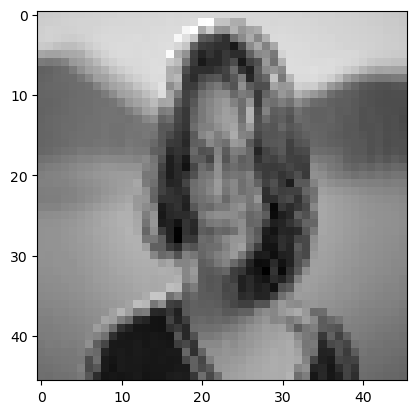

0 - torch.Size([44, 44])


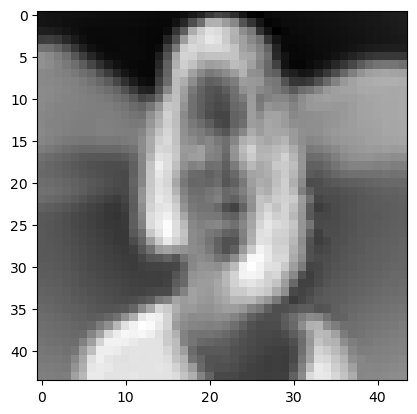

0 - torch.Size([42, 42])


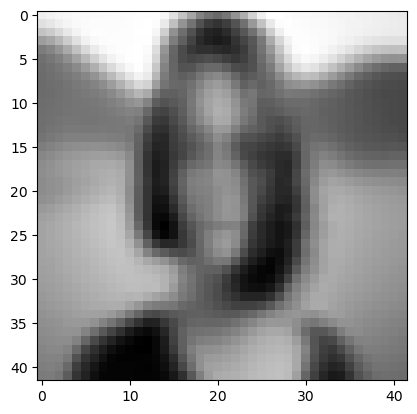

In [20]:
def convert_img_to_tensor(image_path, image_transformer):
    img = Image.open(image_path).convert('L')
    img_tensor = image_transformer(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor
    
def generate_feature_maps(layer, input_tensor):
    with torch.no_grad():
        layer_op = layer(input_tensor)
    
    fig, ax = plt.subplots(4, layer_op.shape[0] // 4, figsize=(20, 20))
    for i in range(layer_op.shape[0]):
        ax[i // 4, i % 4].imshow(layer_op[i, :, :].cpu().numpy(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
        plt.show()
    return layer_op

def generate_feature_map_org(layer, input_tensor):
    with torch.no_grad():
        layer_op = layer(input_tensor)
    
    feature_map = layer_op.squeeze(0)
    feature_map = torch.sum(feature_map, 0)
    feature_map = feature_map / feature_map.shape[0]
    return layer_op, feature_map
    # plt.imshow(feature_map)

def extract_cnn_layers(model_block, output=None):
    if output is None:
        output = []

    for name, child in model_block.named_children():
        if not isinstance(child, nn.Conv2d):
            sub_children = [x for x in child.children()]
            if sub_children:
                output = extract_cnn_layers(child, output)
        else:
            output.append((name, child))
    
    return output
        
conv_layers = extract_cnn_layers(model.eval())
print(f"{len(conv_layers)} CNN layers extracted.")

img_tensor = Image.open("dataset/cnn/photo-1438761681033-6461ffad8d80.jpg").convert('L')
img_tensor = IMAGE_TRANSFORMER(np.array(img_tensor))

# maps = []
input_tensor = img_tensor
for layer_name, layer in conv_layers:
    # input_tensor = generate_feature_maps(layer, input_tensor)
    input_tensor, map = generate_feature_map_org(layer, input_tensor)
    print(f"{layer_name} - {map.shape}")
    # maps.append(map)
    
    plt.imshow(map, cmap='gray')
    plt.show()


In [22]:
img_tensor = Image.open("dataset/cnn/photo-1438761681033-6461ffad8d80.jpg").convert('L')
img_tensor = IMAGE_TRANSFORMER(np.array(img_tensor))

with torch.no_grad():
    y_pred = model(**{"input":img_tensor.unsqueeze(0)})
    
target_encoder.inverse_transform(F.softmax(y_pred, dim=1).argmax(-1).cpu().numpy())[0]

'fear'

In [ ]:
y_pred = MultiClassClassifier.predict(model, data.val_loader)
y_pred

In [176]:
np.unique(y_pred, return_counts=True)

(array([0., 2., 3., 4., 5., 6.]), array([564, 229, 748, 432, 280, 618]))